##Добавление файлов трейн и тест


In [1]:
cd /content/drive/MyDrive/cmc/prac/prac2_toxic

/content/drive/MyDrive/cmc/prac/prac2_toxic


In [2]:
# !unzip data_toxic.zip

##Нужные библиотеки

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

In [4]:
%config InlineBackend.figure_format = 'svg' 

##Создание датафреймов тест и трейн

In [5]:
test = pd.read_csv('toxic_test.csv')
train = pd.read_csv('toxic_train.csv')

In [6]:
train.head(10)

,Unnamed: 0,comment_text,is_toxic
0,0,Explanation\nWhy the edits made under my usern...,False
1,1,D'aww! He matches this background colour I'm s...,False
2,2,"Hey man, I'm really not trying to edit war. It...",False
3,3,"""\nMore\nI can't make any real suggestions on ...",False
4,4,"You, sir, are my hero. Any chance you remember...",False
5,5,"""\n\nCongratulations from me as well, use the ...",False
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True
7,7,Your vandalism to the Matt Shirvington article...,False
8,8,Sorry if the word 'nonsense' was offensive to ...,False
9,9,alignment on this subject and which are contra...,False


In [7]:
test.head()

,Unnamed: 0,comment_text,is_toxic
0,0,Thank you for understanding. I think very high...,False
1,1,:Dear god this site is horrible.,False
2,2,"""::: Somebody will invariably try to add Relig...",False
3,3,""" \n\n It says it right there that it IS a typ...",False
4,4,""" \n\n == Before adding a new product to the l...",False


##Эксперимент 1 преобразование комментариев


In [8]:
re.sub('[^0-9A-Za-z]', ' ', 'a\nbxak9 - 1')

'a bxak9   1'

In [9]:
train.comment_text = train.comment_text.str.lower()
train.comment_text = train.comment_text.apply(lambda row: re.sub('[^0-9A-Za-z]', ' ', row))
train.head()

,Unnamed: 0,comment_text,is_toxic
0,0,explanation why the edits made under my userna...,False
1,1,d aww he matches this background colour i m s...,False
2,2,hey man i m really not trying to edit war it...,False
3,3,more i can t make any real suggestions on im...,False
4,4,you sir are my hero any chance you remember...,False


In [10]:
test.comment_text = test.comment_text.str.lower()
test.comment_text = test.comment_text.apply(lambda row: re.sub('[^0-9A-Za-z]', ' ', row))
test.head()

,Unnamed: 0,comment_text,is_toxic
0,0,thank you for understanding i think very high...,False
1,1,dear god this site is horrible,False
2,2,somebody will invariably try to add relig...,False
3,3,it says it right there that it is a type ...,False
4,4,before adding a new product to the lis...,False


##Эксперемент 2 приведение комментариев к разреженной мтарице

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
train.shape

(52061, 3)

In [13]:
vectorizer = CountVectorizer()
X = vectorizer.fit(train.comment_text)

In [14]:
len(vectorizer.get_feature_names())

89368

Зависимость точности прогноза от min_df

In [15]:
from optimization import GDClassifier

In [16]:
2 * np.array(train.is_toxic).astype(int) - 1

array([-1, -1, -1, ...,  1,  1,  1])

In [27]:
accuracy = []
y_train = 2 * np.array(train.is_toxic).astype(int) - 1
y_test = 2 * np.array(test.is_toxic).astype(int) - 1

for min_df in range (1, 21):
    vectorizer = CountVectorizer(min_df=min_df)
    X_train = vectorizer.fit_transform(train.comment_text)
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.1, step_beta=0.1, tolerance=1e-6, max_iter=1000,
        l2_coef=0.1, batch_size=1)
    
    clf.fit(X_train, y_train)
    X_test = vectorizer.transform(test.comment_text)
    accuracy.append(sum(clf.predict(X_test) == y_test))

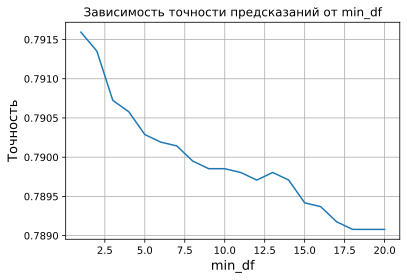

In [37]:
plt.title('Зависимость точности предсказаний от min_df')

plt.plot(np.arange(1, 21), np.array(accuracy) / y_test.shape[0])
# plt.xticks(np.arange(21), ['' if i % 5 else i for i in range(21)])
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('min_df',  fontsize=13)
# plt.savefig(fname='prac2_min_df.pdf', bbox_inches='tight')
plt.show()

In [38]:
vectorizer = CountVectorizer(min_df=1)
X_train = vectorizer.fit_transform(train.comment_text)

In [39]:
len(vectorizer.get_feature_names())

89368

In [40]:
test.shape

(20676, 3)

In [41]:
X_test = vectorizer.transform(test.comment_text)

In [42]:
X_test.shape

(20676, 89368)

In [43]:
X_train.shape

(52061, 89368)

##Эксперимент 3 - зависимости от параметров step_alpha, step_beta, начального приближения:


In [25]:
from optimization import GDClassifier

In [26]:
y_train = 2 * np.array(train.is_toxic).astype(int) - 1
y_test = 2 * np.array(test.is_toxic).astype(int) - 1

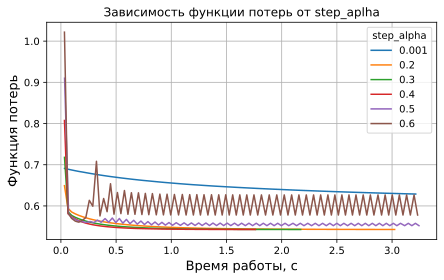

In [59]:
plt.figure(figsize=(7,4))
plt.title('Зависимость функции потерь от step_aplha')

alphas = np.concatenate(([0.001], np.linspace(0.2, 0.6, 5)))
for alpha in alphas:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=0, tolerance=1e-5, max_iter=100,
        l2_coef=0.1, batch_size=1)
    history = clf.fit(X_train, y_train, trace=True)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['func'][1:], label=alpha.round(3))

plt.legend(title='step_alpha', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)

plt.savefig(fname='prac2_alpha1_time.pdf', bbox_inches='tight')
plt.show()

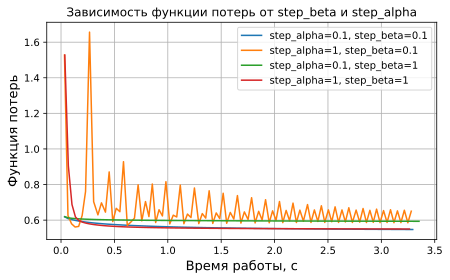

In [76]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от step_beta и step_alpha')

for beta in [0.1, 1]:
    for alpha in [0.1, 1]:
        clf = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta, tolerance=1e-6, max_iter=100,
            l2_coef=0.1, batch_size=1)
        history = clf.fit(X_train, y_train, trace=True)
        plt.plot(np.array(history['time'][1:]).cumsum(), history['func'][1:], label='step_alpha={}, step_beta={}'.format(alpha, beta))

plt.legend(loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)

plt.savefig(fname='prac2_alpha_beta_time.pdf', bbox_inches='tight')
plt.show()

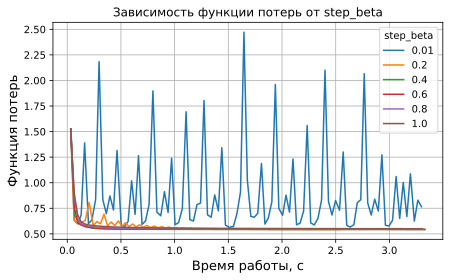

In [72]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от step_beta')

for beta in np.concatenate(([0.01], np.linspace(0.2, 1, 5))):
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=beta, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=1)
    history = clf.fit(X_train, y_train, trace=True)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['func'][1:], label=beta.round(3))

plt.legend(title='step_beta', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)

plt.savefig(fname='prac2_beta1_time.pdf', bbox_inches='tight')
plt.show()

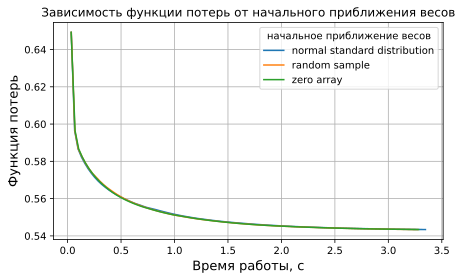

In [87]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от начального приближения весов')

w0_array = [np.random.normal(0, 1000, X_train.shape[0]), np.random.random_sample(X_train.shape[0]), np.zeros(X_train.shape[0])]
for w0 in w0_array:
    clf = GDClassifier(loss_function='binary_logistic', w0=w0, step_alpha=0.2, step_beta=0.1, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=1)
    history = clf.fit(X_train, y_train, trace=True)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['func'][1:])

plt.legend(labels=['normal standard distribution', 'random sample', 'zero array'], title='начальное приближение весов', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)

plt.savefig(fname='prac2_weights1_time.pdf', bbox_inches='tight')
plt.show()

## Эксперимент 3 с точностью

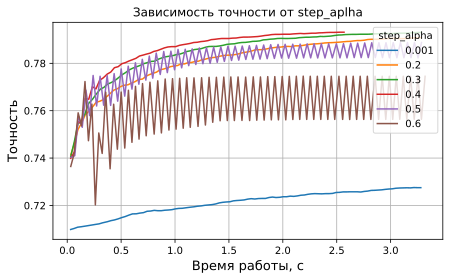

In [63]:
plt.figure(figsize=(7,4))
plt.title('Зависимость точности от step_aplha')

alphas = np.concatenate(([0.001], np.linspace(0.2, 0.6, 5)))
for alpha in alphas:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=0, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=1)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['accuracy'][1:], label=alpha.round(3))

plt.legend(title='step_alpha', loc='upper right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)

plt.savefig(fname='prac2_alpha2_time.pdf', bbox_inches='tight')
plt.show()

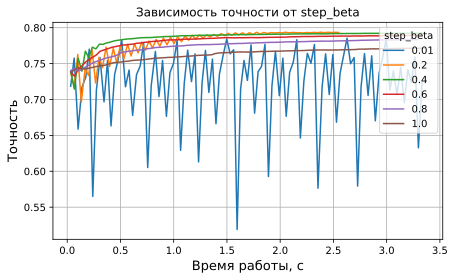

In [70]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от step_beta')

for beta in np.concatenate(([0.01], np.linspace(0.2, 1, 5))):
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=beta, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=1)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['accuracy'][1:], label=beta.round(3))

plt.legend(title='step_beta', loc='upper right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)

plt.savefig(fname='prac2_beta2_time.pdf', bbox_inches='tight')
plt.show()

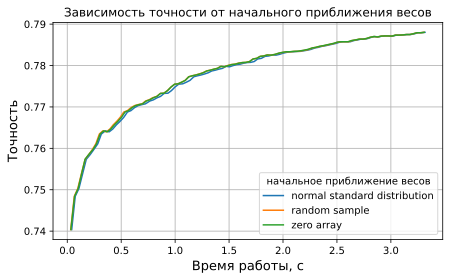

In [94]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от начального приближения весов')

for w0 in w0_array:
    
    clf = GDClassifier(loss_function='binary_logistic', w0=w0, step_alpha=0.2, step_beta=0.1, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=1)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['accuracy'][1:], label=w0)

plt.legend(labels=['normal standard distribution', 'random sample', 'zero array'], title='начальное приближение весов', loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)

plt.savefig(fname='prac2_weights2_time.pdf', bbox_inches='tight')
plt.show()

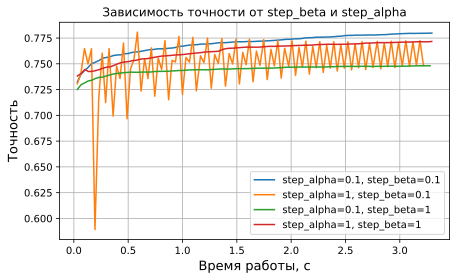

In [78]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от step_beta и step_alpha')

for beta in [0.1, 1]:
    for alpha in [0.1, 1]:
        clf = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta, tolerance=1e-6, max_iter=100,
            l2_coef=0.1, batch_size=1)
        history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
        plt.plot(np.array(history['time'][1:]).cumsum(), history['accuracy'][1:], label='step_alpha={}, step_beta={}'.format(alpha, beta))

plt.legend(loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)

plt.savefig(fname='prac2_alpha_beta_accuracy.pdf', bbox_inches='tight')
plt.show()

## Эксперимет 3 с итерацией

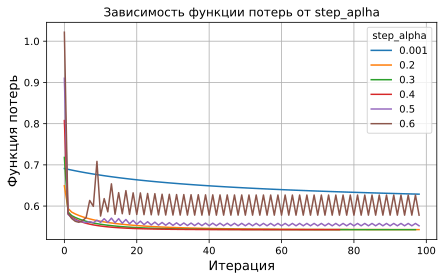

In [60]:
plt.figure(figsize=(7,4))
plt.title('Зависимость функции потерь от step_aplha')

alphas = np.concatenate(([0.001], np.linspace(0.2, 0.6, 5)))
for alpha in alphas:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=0, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=1)
    history = clf.fit(X_train, y_train, trace=True)
    plt.plot(history['func'][1:], label=alpha.round(3))

plt.legend(title='step_alpha', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)

plt.savefig(fname='prac2_alpha1_iteration.pdf', bbox_inches='tight')
plt.show()

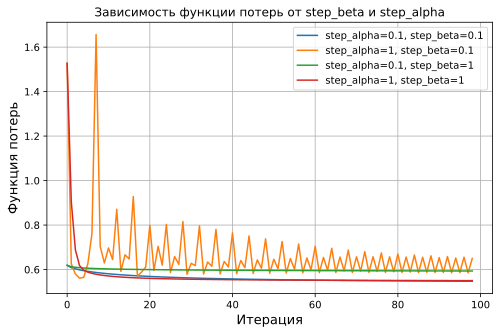

In [ ]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от step_beta и step_alpha')

for beta in [0.1, 1]:
    for alpha in [0.1, 1]:
        clf = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta, tolerance=1e-6, max_iter=100,
            l2_coef=0.1, batch_size=1)
        history = clf.fit(X_train, y_train, trace=True)
        plt.plot(history['func'][1:], label='step_alpha={}, step_beta={}'.format(alpha, beta))

plt.legend(loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)
plt.show()

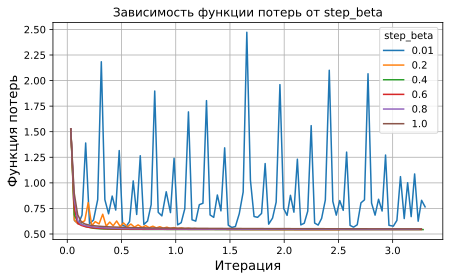

In [69]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от step_beta')

for beta in np.concatenate(([0.01], np.linspace(0.2, 1, 5))):
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=beta, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=1)
    history = clf.fit(X_train, y_train, trace=True)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['func'][1:], label=beta.round(3))

plt.legend(title='step_beta', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)

plt.savefig(fname='prac2_beta1_iteration.pdf', bbox_inches='tight')
plt.show()

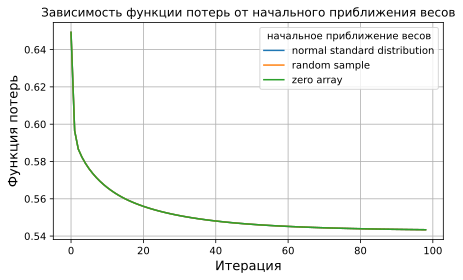

In [93]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от начального приближения весов')

w0_array = [np.random.normal(0, 1000, X_train.shape[0]), np.random.random_sample(X_train.shape[0]), np.zeros(X_train.shape[0])]

for w0 in w0_array:
    
    clf = GDClassifier(loss_function='binary_logistic', w0=w0, step_alpha=0.2, step_beta=0.1, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=1)
    history = clf.fit(X_train, y_train, trace=True)
    plt.plot(history['func'][1:], label=w0)

plt.legend(labels=['normal standard distribution', 'random sample', 'zero array'], title='начальное приближение весов', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)

plt.savefig(fname='prac2_weights1_iteration.pdf', bbox_inches='tight')
plt.show()

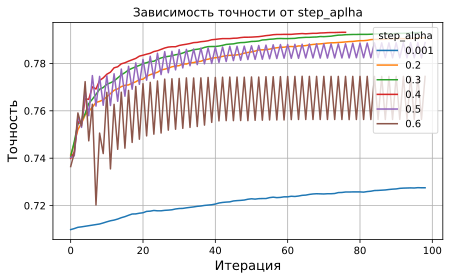

In [61]:
plt.figure(figsize=(7,4))
plt.title('Зависимость точности от step_aplha')

alphas = np.concatenate(([0.001], np.linspace(0.2, 0.6, 5)))
for alpha in alphas:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=0, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=1)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(history['accuracy'][1:], label=alpha.round(3))

plt.legend(title='step_alpha', loc='upper right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)


plt.savefig(fname='prac2_alpha2_itration.pdf', bbox_inches='tight')
plt.show()

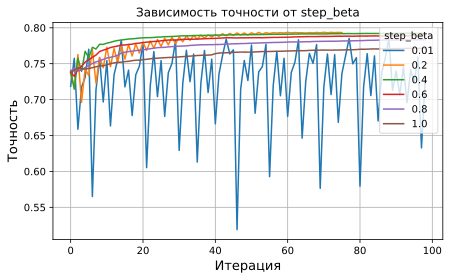

In [71]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от step_beta')

for beta in np.concatenate(([0.01], np.linspace(0.2, 1, 5))):
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=beta, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=1)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(history['accuracy'][1:], label=beta.round(3))

plt.legend(title='step_beta', loc='upper right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)

plt.savefig(fname='prac2_beta2_iteration.pdf', bbox_inches='tight')
plt.show()

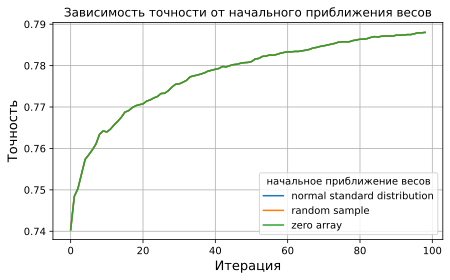

In [95]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от начального приближения весов')

w0_array = [np.random.normal(0, 1000, X_train.shape[0]), np.random.random_sample(X_train.shape[0]), np.zeros(X_train.shape[0])]
for w0 in w0_array:
    clf = GDClassifier(loss_function='binary_logistic', w0=w0, step_alpha=0.2, step_beta=0.1, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=1)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(history['accuracy'][1:], label=w0)

plt.legend(labels=['normal standard distribution', 'random sample', 'zero array'], title='начальное приближение весов', loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)

plt.savefig(fname='prac2_weights2_iteration.pdf', bbox_inches='tight')
plt.show()

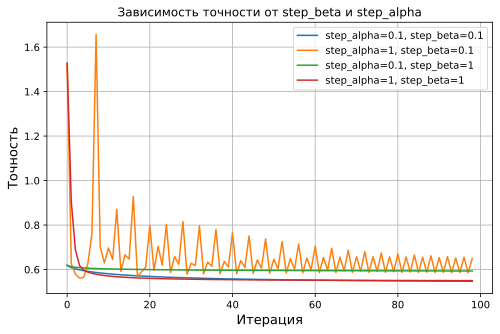

In [ ]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от step_beta и step_alpha')

for beta in [0.1, 1]:
    for alpha in [0.1, 1]:
        clf = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta, tolerance=1e-6, max_iter=100,
            l2_coef=0.1, batch_size=1)
        history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
        plt.plot(history['func'][1:], label='step_alpha={}, step_beta={}'.format(alpha, beta))

plt.legend(loc='upper right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)
plt.show()

##Эксперемент 4. Исследование стохастического градиентного спуска

In [96]:
from optimization import SGDClassifier

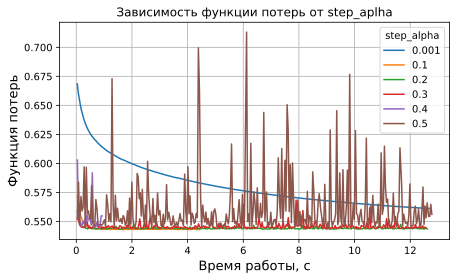

In [116]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от step_aplha')

alphas = np.concatenate(([0.001], np.linspace(0.1, 0.5, 5)))
for alpha in alphas:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=0, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=2000)
    history = clf.fit(X_train, y_train, trace=True, log_freq = 0.3)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['func'][1:], label=alpha.round(3))

plt.legend(title='step_alpha', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)


plt.savefig(fname='prac2_sgd_alpha1_time.pdf', bbox_inches='tight')
plt.show()

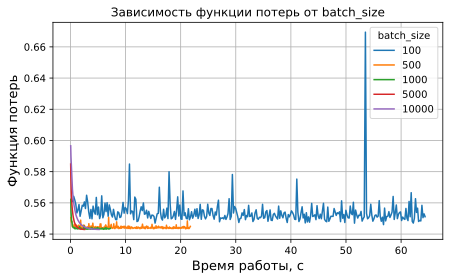

In [122]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от batch_size')

for batch_size in [100, 500, 1000, 5000, 10000]:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.1, step_beta=0.1, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=batch_size)
    history = clf.fit(X_train, y_train, trace=True, log_freq=0.3)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['func'][1:], label=batch_size)

plt.legend(title='batch_size', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)


plt.savefig(fname='prac2_sgd_batch1_time.pdf', bbox_inches='tight')
plt.show()

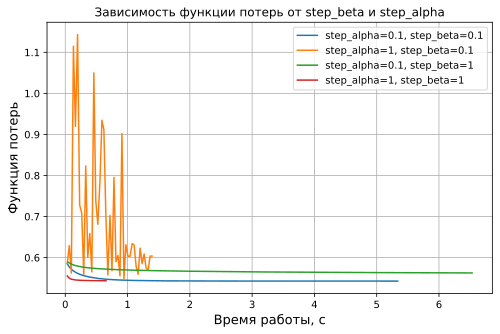

In [ ]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь batcjstep_beta и step_alpha')

for beta in [0.1, 1]:
    for alpha in [0.1, 1]:
        clf = SGDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta, tolerance=1e-6, max_iter=200,
        l2_coef=0.1, batch_size=5000)
        history = clf.fit(X_train, y_train, trace=True, log_freq=0.3)
        plt.plot(np.array(history['time'][1:]).cumsum(), history['func'][1:], label='step_alpha={}, step_beta={}'.format(alpha, beta))

plt.legend(loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)
plt.show()

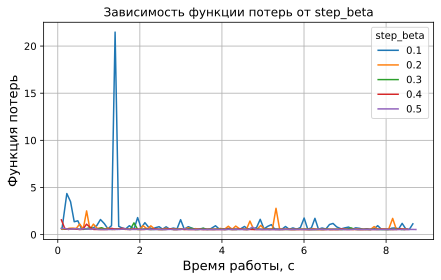

In [126]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от step_beta')

for beta in np.linspace(0.1, 0.5, 5):
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=beta, tolerance=1e-6, max_iter=100,
      l2_coef=0.1, batch_size=2000)
    history = clf.fit(X_train, y_train, trace=True)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['func'][1:], label=beta.round(3))

plt.legend(title='step_beta', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)


plt.savefig(fname='prac2_sgd_beta1_time.pdf', bbox_inches='tight')
plt.show()

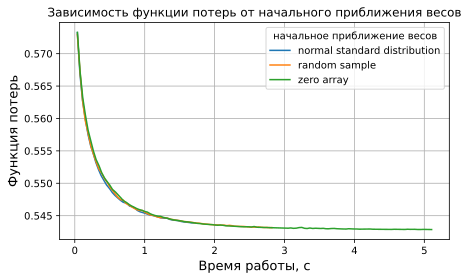

In [135]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от начального приближения весов')

w0_array = [np.random.normal(0, 1000, X_train.shape[0]), np.random.random_sample(X_train.shape[0]), np.zeros(X_train.shape[0])]
for w0 in w0_array:
    
    clf = SGDClassifier(loss_function='binary_logistic', w0=w0, step_alpha=0.1, step_beta=0.4, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=2000)
    history = clf.fit(X_train, y_train, trace=True, log_freq=0.3)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['func'][1:], label=w0)

plt.legend(labels=['normal standard distribution', 'random sample', 'zero array'], title='начальное приближение весов', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)

plt.savefig(fname='prac2_sgd_weights1_time.pdf', bbox_inches='tight')
plt.show()

## Эксперимент 4 с точностью

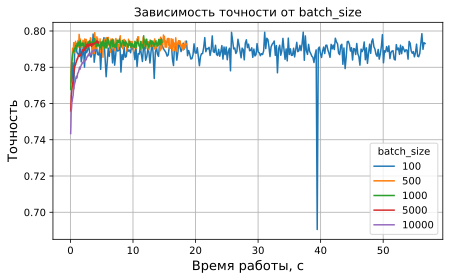

In [120]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от batch_size')

for batch_size in [100, 500, 1000, 5000, 10000]:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.1, step_beta=0.1, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=batch_size)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test, log_freq=0.3)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['accuracy'][1:], label=batch_size)

plt.legend(title='batch_size', loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)


plt.savefig(fname='prac2_sgd_batch2_time.pdf', bbox_inches='tight')
plt.show()

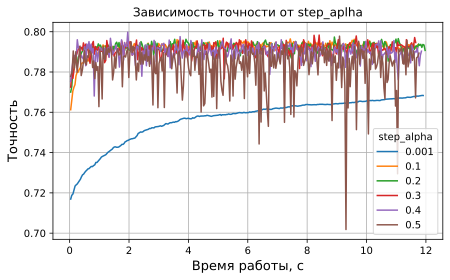

In [117]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от step_aplha')

for alpha in alphas:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=0, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=2000)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test, log_freq=0.3)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['accuracy'][1:], label=alpha.round(3))

plt.legend(title='step_alpha', loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)

plt.savefig(fname='prac2_sgd_alpha2_time.pdf', bbox_inches='tight')
plt.show()

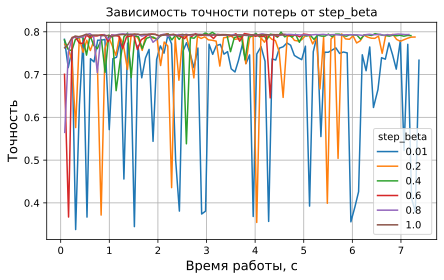

In [129]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности потерь от step_beta')

for beta in np.concatenate(([0.01], np.linspace(0.2, 1, 5))):
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=beta, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=2000)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['accuracy'][1:], label=beta.round(3))

plt.legend(title='step_beta', loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)


plt.savefig(fname='prac2_sgd_beta2_time.pdf', bbox_inches='tight')
plt.show()

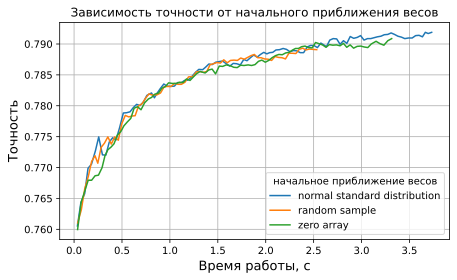

In [136]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от начального приближения весов')

for w0 in w0_array:
    clf = SGDClassifier(loss_function='binary_logistic', w0=w0, step_alpha=0.1, step_beta=0.4, tolerance=1e-6, max_iter=100,
          l2_coef=0.1, batch_size=2000)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test, log_freq=0.3)
    plt.plot(np.array(history['time'][1:]).cumsum(), history['accuracy'][1:], label=w0)

plt.legend(labels=['normal standard distribution', 'random sample', 'zero array'], title='начальное приближение весов', loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)

plt.savefig(fname='prac2_sgd_weights2_time.pdf', bbox_inches='tight')
plt.show()

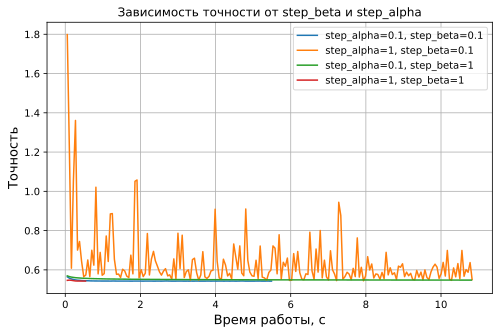

In [ ]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от step_beta и step_alpha')

for beta in [0.1, 1]:
    for alpha in [0.1, 1]:
        clf = SGDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta, tolerance=1e-6, max_iter=200,
          l2_coef=0.1, batch_size=5000)
        history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
        plt.plot(np.array(history['time'][1:]).cumsum(), history['func'][1:], label='step_alpha={}, step_beta={}'.format(alpha, beta))

plt.legend(loc='upper right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)
plt.show()

## Эксперимет 4 с номером эпохи

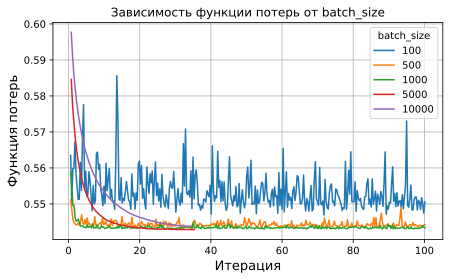

In [138]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от batch_size')

for batch_size in [100, 500, 1000, 5000, 10000]:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.1, step_beta=0.1, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=batch_size)
    history = clf.fit(X_train, y_train, trace=True, log_freq=0.3)
    plt.plot(np.array(history['epoch_num'][1:]), history['func'][1:], label=batch_size)

plt.legend(title='batch_size', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)


plt.savefig(fname='prac2_sgd_batch1_epoch.pdf', bbox_inches='tight')
plt.show()

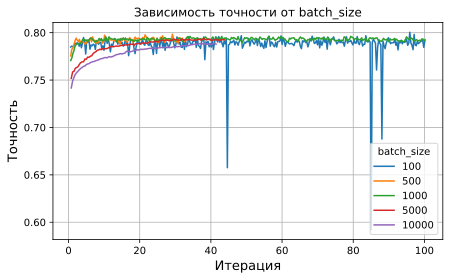

In [139]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от batch_size')

for batch_size in [100, 500, 1000, 5000, 10000]:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.1, step_beta=0.1, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=batch_size)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test, log_freq=0.3)
    plt.plot(np.array(history['epoch_num'][1:]), history['accuracy'][1:], label=batch_size)

plt.legend(title='batch_size', loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)


plt.savefig(fname='prac2_sgd_batch2_epoch.pdf', bbox_inches='tight')
plt.show()

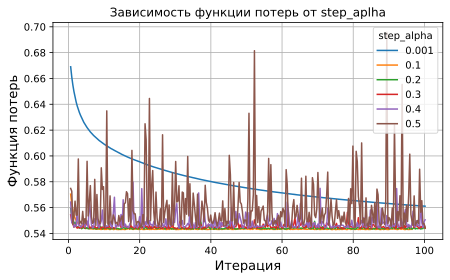

In [118]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от step_aplha')

for alpha in alphas:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=0, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=2000)
    history = clf.fit(X_train, y_train, trace=True, log_freq=0.3)
    plt.plot(history['epoch_num'][1:], history['func'][1:], label=alpha.round(3))

plt.legend(title='step_alpha', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)


plt.savefig(fname='prac2_sgd_alpha1_epoch.pdf', bbox_inches='tight')
plt.show()

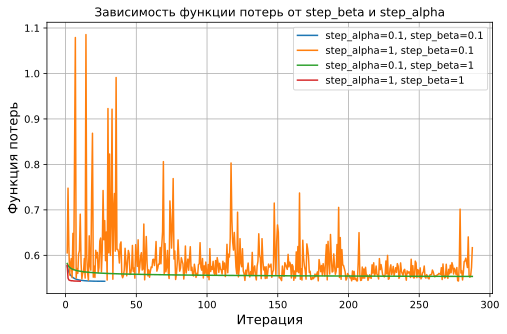

In [ ]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от step_beta и step_alpha')

for beta in [0.1, 1]:
    for alpha in [0.1, 1]:
        clf = SGDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta, tolerance=1e-6, max_iter=500,
            l2_coef=0.1, batch_size=5000)
        history = clf.fit(X_train, y_train, trace=True, log_freq=0.5)
        plt.plot(history['epoch_num'][1:], history['func'][1:], label='step_alpha={}, step_beta={}'.format(alpha, beta))

plt.legend(loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)
plt.show()

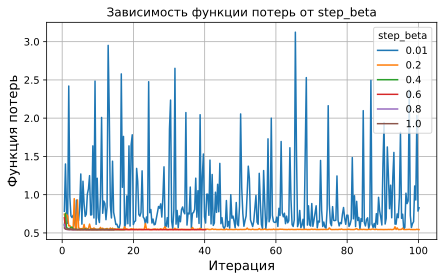

In [137]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от step_beta')

for beta in np.concatenate(([0.01], np.linspace(0.2, 1, 5))):
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=beta, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=2000)
    history = clf.fit(X_train, y_train, trace=True, log_freq=0.3)
    plt.plot(history['epoch_num'][1:], history['func'][1:], label=beta.round(3))

plt.legend(title='step_beta', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)


plt.savefig(fname='prac2_sgd_beta1_epoch.pdf', bbox_inches='tight')
plt.show()

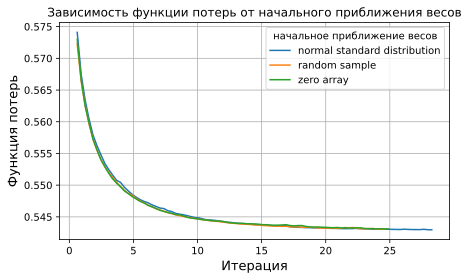

In [132]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость функции потерь от начального приближения весов')


for w0 in w0_array:
    clf = SGDClassifier(loss_function='binary_logistic', w0=w0, step_alpha=0.1, step_beta=0.4, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=2000)
    history = clf.fit(X_train, y_train, trace=True, log_freq=0.3)
    plt.plot(history['epoch_num'][1:], history['func'][1:], label=w0)

plt.legend(labels=['normal standard distribution', 'random sample', 'zero array'], title='начальное приближение весов', loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)


plt.savefig(fname='prac2_sgd_weights1_epoch.pdf', bbox_inches='tight')
plt.show()

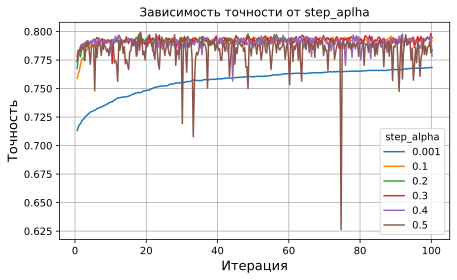

In [119]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от step_aplha')

for alpha in alphas:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=0, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=2000)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test, log_freq=0.3)
    plt.plot(history['epoch_num'][1:], history['accuracy'][1:], label=alpha.round(3))

plt.legend(title='step_alpha', loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)

plt.savefig(fname='prac2_sgd_alpha2_epoch.pdf', bbox_inches='tight')
plt.show()

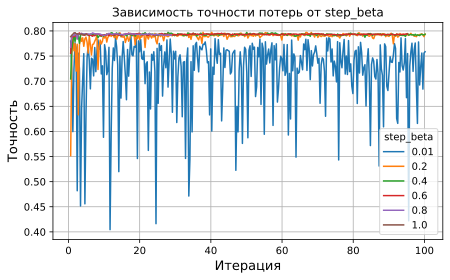

In [130]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности потерь от step_beta')

for beta in np.concatenate(([0.01], np.linspace(0.2, 1, 5))):
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=beta, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=2000)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test, log_freq=0.3)
    plt.plot(history['epoch_num'][1:], history['accuracy'][1:], label=beta.round(3))

plt.legend(title='step_beta', loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)

plt.savefig(fname='prac2_sgd_beta2_epoch.pdf', bbox_inches='tight')
plt.show()

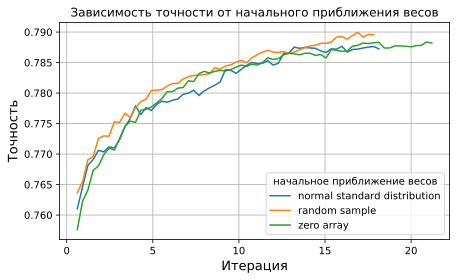

In [133]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от начального приближения весов')

for w0 in w0_array:
    clf = SGDClassifier(loss_function='binary_logistic', w0=w0, step_alpha=0.1, step_beta=0.4, tolerance=1e-6, max_iter=100,
        l2_coef=0.1, batch_size=2000)
    history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test, log_freq=0.3)
    plt.plot(history['epoch_num'][1:], history['accuracy'][1:], label=w0)

plt.legend(labels=['normal standard distribution', 'random sample', 'zero array'], title='начальное приближение весов', loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)


plt.savefig(fname='prac2_sgd_weights2_epoch.pdf', bbox_inches='tight')
plt.show()

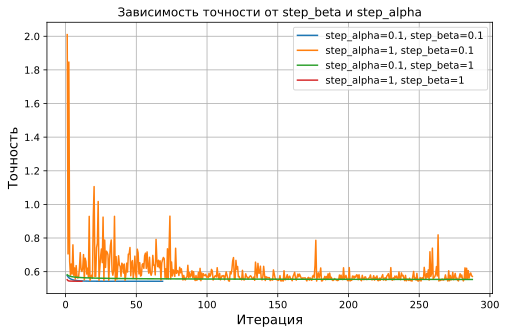

In [ ]:
plt.figure(figsize=(7, 4))
plt.title('Зависимость точности от step_beta и step_alpha')

for beta in [0.1, 1]:
    for alpha in [0.1, 1]:
        clf = SGDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta, tolerance=1e-6, max_iter=500,
            l2_coef=0.1, batch_size=5000)
        history = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test, log_freq=0.5)
        plt.plot(history['epoch_num'][1:], history['func'][1:], label='step_alpha={}, step_beta={}'.format(alpha, beta))

plt.legend(loc='upper right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)
plt.show()

## Сравнение методов

In [213]:
clf1 = SGDClassifier(loss_function='binary_logistic', step_alpha=0.8, step_beta=0.2, tolerance=1e-6, max_iter=2000,
    l2_coef=0.1, batch_size=2000)
history1 = clf1.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test, log_freq=0.5)

clf2 = GDClassifier(loss_function='binary_logistic', step_alpha=0.8, step_beta=0.2, tolerance=1e-6, max_iter=2000,
    l2_coef=0.1, batch_size=1)
history2 = clf2.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test)


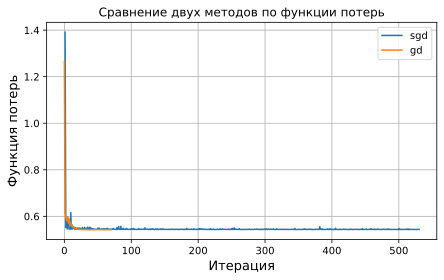

In [167]:
plt.figure(figsize=(7, 4))
plt.title('Сравнение двух методов по функции потерь')


plt.plot(history1['epoch_num'][1:], history1['func'][1:])
plt.plot(history2['func'][1:])

plt.legend(labels=['sgd', 'gd'], loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)


plt.savefig(fname='prac2_sgd_gd2_iteration.pdf', bbox_inches='tight')
plt.show()

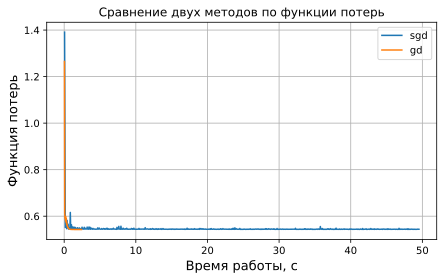

In [175]:
plt.figure(figsize=(7, 4))
plt.title('Сравнение двух методов по функции потерь')


plt.plot(np.array(history1['time'][1:]).cumsum(), history1['func'][1:])
plt.plot(np.array(history2['time'][1:]).cumsum(), history2['func'][1:])

plt.legend(labels=['sgd', 'gd'], loc='upper right')
plt.grid(True) 
plt.ylabel('Функция потерь',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)


plt.savefig(fname='prac2_sgd_gd2_time.pdf', bbox_inches='tight')
plt.show()

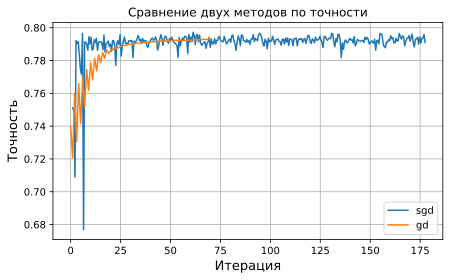

In [214]:
plt.figure(figsize=(7, 4))
plt.title('Сравнение двух методов по точности')


plt.plot(history1['epoch_num'][1:], history1['accuracy'][1:])
plt.plot(history2['accuracy'][1:])

plt.legend(labels=['sgd', 'gd'], loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)


plt.savefig(fname='prac2_sgd_gd1_iteration.pdf', bbox_inches='tight')
plt.show()

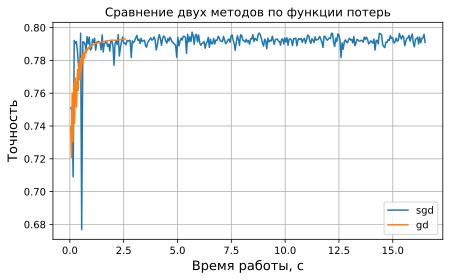

In [215]:
plt.figure(figsize=(7, 4))
plt.title('Сравнение двух методов по функции потерь')


plt.plot(np.array(history1['time'][1:]).cumsum(), history1['accuracy'][1:])
plt.plot(np.array(history2['time'][1:]).cumsum(), history2['accuracy'][1:])

plt.legend(labels=['sgd', 'gd'], loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Время работы, с',  fontsize=13)


plt.savefig(fname='prac2_sgd_gd1_time.pdf', bbox_inches='tight')
plt.show()

##Лемматизация и удаление стоп слов

In [186]:
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [180]:
len(vectorizer.get_feature_names())

89368

In [189]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize("sucks")

'suck'

In [196]:
X_train2 = []
for document in train.comment_text:
    split_document = document.split(' ')
    new_document = []
    for word in split_document:
        new_document.append(lemmatizer.lemmatize(word))
    X_train2.append(' '.join(new_document))

In [200]:
X_test2 = []
for document in test.comment_text:
    split_document = document.split(' ')
    new_document = []
    for word in split_document:
        new_document.append(lemmatizer.lemmatize(word))
    X_test2.append(' '.join(new_document))

In [199]:
X_train2 = vectorizer.fit_transform(X_train2)

In [202]:
X_test2 = vectorizer.transform(X_test2)

In [201]:
len(vectorizer.get_feature_names())

82991

In [203]:
X_train2.shape

(52061, 82991)

In [204]:
X_test2.shape

(20676, 82991)

In [229]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.1, step_beta=0.4, tolerance=1e-6, max_iter=200,
    l2_coef=0.1)
history1 = clf.fit(X_train, y_train, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
history2 = clf.fit(X_train2, y_train, trace=True, accuracy=True, X_test=X_test2, y_test=y_test)

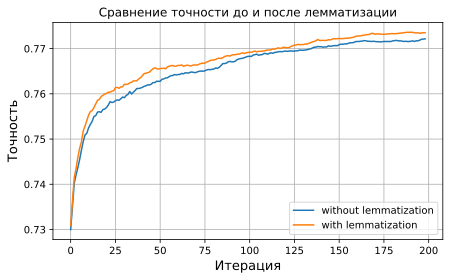

In [210]:
plt.figure(figsize=(7, 4))
plt.title('Сравнение точности до и после лемматизации')


plt.plot(history1['accuracy'][1:])
plt.plot(history2['accuracy'][1:])

plt.legend(labels=['without lemmatization', 'with lemmatization'], loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)


plt.savefig(fname='prac2_lemmatization.pdf', bbox_inches='tight')
plt.show()

In [216]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [218]:
stops = set(stopwords.words("english"))

In [233]:
X_train3 = []
for document in train.comment_text:
    split_document = document.split(' ')
    new_document = []
    for word in split_document:
        word = lemmatizer.lemmatize(word)
        if word not in stops:
            new_document.append(word)
    X_train3.append(' '.join(new_document))

In [237]:
X_test3 = []
for document in test.comment_text:
    split_document = document.split(' ')
    new_document = []
    for word in split_document:
        word = lemmatizer.lemmatize(word)
        if word not in stops:
            new_document.append(word)

    X_test3.append(' '.join(new_document))

In [234]:
X_train3 = vectorizer.fit_transform(X_train3)

In [238]:
X_test3 = vectorizer.transform(X_test3)

In [224]:
len(vectorizer.get_feature_names())

82876

In [242]:
X_train.shape

(52061, 89368)

In [244]:
X_train2.shape

(52061, 82991)

In [245]:
X_train3.shape

(52061, 82851)

In [239]:
X_test3.shape

(20676, 82851)

In [240]:
history3 = clf.fit(X_train3, y_train, trace=True, accuracy=True, X_test=X_test3, y_test=y_test)

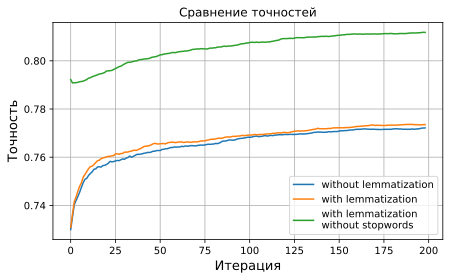

In [246]:
plt.figure(figsize=(7, 4))
plt.title('Сравнение точностей')


plt.plot(history1['accuracy'][1:])
plt.plot(history2['accuracy'][1:])
plt.plot(history3['accuracy'][1:])

plt.legend(labels=['without lemmatization', 'with lemmatization', 'with lemmatization\nwithout stopwords'], loc='lower right')
plt.grid(True) 
plt.ylabel('Точность',  fontsize=13)
plt.xlabel('Итерация',  fontsize=13)


plt.savefig(fname='prac2_lemmatization.pdf', bbox_inches='tight')
plt.show()

In [248]:
np.array(history1['time']).cumsum()[-1]

6.9595184326171875

In [249]:
np.array(history2['time']).cumsum()[-1]

6.7118470668792725

In [250]:
np.array(history3['time']).cumsum()[-1]

5.228826284408569

## Анализ ошибок

In [251]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.1, step_beta=0.4, tolerance=1e-6, max_iter=1500,
    l2_coef=0.1)
history4 = clf.fit(X_train3, y_train, trace=True, accuracy=True, X_test=X_test3, y_test=y_test)

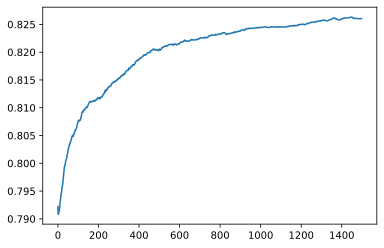

In [252]:

plt.plot(history4['accuracy'][1:])

In [253]:
history4['accuracy'][-1]

0.8260785451731476

In [254]:
ans = clf.predict(X_test3)

In [255]:
comments = []
for document in test.comment_text:
    split_document = document.split(' ')
    new_document = []
    for word in split_document:
        word = lemmatizer.lemmatize(word)
        if word not in stops:
            new_document.append(word)

    comments.append(' '.join(new_document))

In [262]:
(y_test[ans!=y_test] == 1).sum()

2472

In [263]:
(y_test[ans!=y_test] == -1).sum()

1124

In [258]:
for i in range(1000):
    if ans[i] != y_test[i]:
        print(comments[i], '\n', test.comment_text[i], '\n y_test = ', y_test[i])

 dear god site horrible  
  dear god this site is horrible  
 y_test =  -1
   arab committing genocide iraq  protest europe        may europe also burn hell  
    arabs are committing genocide in iraq  but no protests in europe        may europe also burn in hell  
 y_test =  1
               jew race get mother  mention ethiopian jew testing             jew prof  well fact accept convert 
                jews are not a race because you can only get it from your mother  your own mention of ethiopian jews not testing             as jews proves it is not  as well as the fact that we accept converts 
 y_test =  -1
                             
                              
 y_test =  -1
puwersa ng masa  
 puwersa ng masa  
 y_test =  -1
dare vandalize page hm beagle  vandalize  demon  
 how dare you vandalize that page about the hms beagle  don t vandalize again  demon  
 y_test =  1
aapn bhtla aanand jhala   
 aapn bhtla aanand jhala   
 y_test =  -1
                                    